# PXD002801 Gygi lab mouse liver re-analysis (mouse mousse?)

## CC Strains

## Quality control and sanity check notebook

### performed by Phil Wilmarth, PSR Core OHSU

#### November 3, 2025

---

- [Overview](#overview) 
- [Data loading](#load_data)
- [Removing plex effects with IRS](#IRS)
- [TMM normalization and final clustering](#TMM)
- [CV distributions](#CVs)
- [Sample-to-sample scatter plots](#scatter_plots)
- [Summary](#summary)

---

## <a name="overview"></a>Overview

This is a three plex experiment using 10-plex TMT (8 of the 10 channels were used) with no reference channels per plex. Each plex is a set of biological replicates of mouse livers from the CC experiment (CC-001, CC-003, CC-004, and CC-017 strains). Each plex has a male and a female mouse from each strain (8 channels) with repeated biological replicates in the 3 plexes (24 samples in total). Data were downloaded from PRIDE (PXD002801) and processed with the [PAW Pipeline](https://github.com/pwilmart/PAW_pipeline) (*Wilmarth 2009*) and IRS normalized using the average of each plex as a mock reference channel. This is the publication:

> Chick, J.M., Munger, S.C., Simecek, P., Huttlin, E.L., Choi, K., Gatti, D.M., Raghupathy, N., Svenson, K.L., Churchill, G.A. and Gygi, S.P., 2016. Defining the consequences of genetic variation on a proteome-wide scale. Nature, 534(7608), pp.500-505.

This QC notebook will address these questions:

- Do the samples cluster by biological group or by TMT plex?
- Are normalization factors small and consistent?
- Are samples within groups similar to each other?

#### Sample Key:

Channel|Set3|Set4|Set5
---|---|---|---
126c|CC017_M|CC017_M|CC017_M
127n|CC017_F|CC017_F|CC017_F
127c|CC004_M|CC004_M|CC004_M
128n|unused|unused|unused
128c|CC004_F|CC004_F|CC004_F
129n|CC001_M|CC001_M|CC001_M
129c|CC001_F|CC001_F|CC001_F
130n|unused|unused|unused
130c|CC003_M|CC003_M|CC003_M
131n|CC003_F|CC003_F|CC003_F
131c|Pool|Pool|Pool

This is a very balanced study design, so the average intensities for each protein in each plex should work well for IRS.

### References

> Wilmarth, P.A., Riviere, M.A. and David, L.L., 2009. Techniques for accurate protein identification in shotgun proteomic studies of human, mouse, bovine, and chicken lenses. Journal of ocular biology, diseases, and informatics, 2(4), pp.223-234.

> Plubell, D.L., Wilmarth, P.A., Zhao, Y., Fenton, A.M., Minnier, J., Reddy, A.P., Klimek, J., Yang, X., David, L.L. and Pamir, N., 2017. Extended multiplexing of tandem mass tags (TMT) labeling reveals age and high fat diet specific proteome changes in mouse epididymal adipose tissue. Molecular & Cellular Proteomics, 16(5), pp.873-890.

---

## This notebook examines quality control metrics

---

## Load the necessary R libraries

In [13]:
# library imports
library(tidyverse)
library(scales)
library(limma)
library(edgeR)
library(psych)

## Define common functions for notebook use

In [14]:
# ================== TMM normalization from DGEList object =====================
apply_tmm_factors <- function(y, color = NULL, plot = TRUE) {
    # computes the tmm normalized data from the DGEList object
        # y - DGEList object
        # returns a dataframe with normalized intensities
    
    # compute and print "Sample loading" normalization factors
    lib_facs <- mean(y$samples$lib.size) / y$samples$lib.size
    cat("\nLibrary size factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), lib_facs))
    
    # compute and print TMM normalization factors
    tmm_facs <- 1/y$samples$norm.factors
    cat("\nTrimmed mean of M-values (TMM) factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), tmm_facs))
    
    # compute and print the final correction factors
    norm_facs <- lib_facs * tmm_facs
    cat("\nCombined (lib size and TMM) normalization factors:\n", 
        sprintf("%-5s -> %f\n", colnames(y$counts), norm_facs))

    # compute the normalized data as a new data frame
    tmt_tmm <- as.data.frame(sweep(y$counts, 2, norm_facs, FUN = "*"))
    colnames(tmt_tmm) <- str_c(colnames(y$counts), "_tmm")
    
    # visualize results and return data frame
    if(plot == TRUE) {
        boxplot(log10(tmt_tmm), col = color, notch = TRUE, main = "TMM Normalized data")
    }
    tmt_tmm
}

# ============== CV function ===================================================
CV <- function(df) {
    # Computes CVs of data frame rows
        # df - data frame, 
        # returns vector of CVs (%)
    ave <- rowMeans(df)    # compute averages
    sd <- apply(df, 1, sd) # compute standard deviations
    cv <- 100 * sd / ave   # compute CVs in percent (last thing gets returned)
}

# =========== Boxplot with median label ========================================
labeled_boxplot <- function(df, ylim, title) {
    # Makes a box plot with the median value labeled
        # df - data frame with data to compute CVs of
        # ylim - upper limit for y-axis
        # title - plot title
    cv = CV(df)
    boxplot(cv, ylim = c(0, ylim), notch = TRUE, main = title)
    text(x = 0.65, y = boxplot.stats(cv)$stats[3], 
         labels = round(boxplot.stats(cv)$stats[3], 1))
}

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width=width_choice, repr.plot.height=height_choice)
}

## <a name="load_data"></a>Load the IRS-normalized TMT intensity data

The IRS-adjusted quantitative data was prepped in Excel. The IRS script excludes any flagged proteins (decoys, contaminants, blood proteins, etc.) and restricts the IRS adjustment to proteins seen in all three plexes. The IRS adjusted data was saved to a tab-delimited text file for input into this script.  

In [15]:
# load the IRS-normalized data and check the table
data_irs <- read_tsv("quant_table.txt") 

# save gene names for edgeR so we can double check that results line up
accessions <- data_irs$Accession

# see how many rows of data we have
length(accessions)

Rows: 5541 Columns: 28
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Accession
dbl (27): CC017_M_1, CC017_F_1, CC004_M_1, CC004_F_1, CC001_M_1, CC001_F_1, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 5541

### Collect channels by biological conditions 

In [16]:
# define the groups (after IRS)
CC_001_F <- select(data_irs, contains("CC001_F"))
CC_001_M <- select(data_irs, contains("CC001_M"))
CC_003_F <- select(data_irs, contains("CC003_F"))
CC_003_M <- select(data_irs, contains("CC003_M"))
CC_004_F <- select(data_irs, contains("CC004_F"))
CC_004_M <- select(data_irs, contains("CC004_M"))
CC_017_F <- select(data_irs, contains("CC017_F"))
CC_017_M <- select(data_irs, contains("CC017_M"))

### Make the organized data frames

We will put the organized data into a new data frame, define some column indexes for each biological group, and set colors for plotting.

In [17]:
# put groups together into a single data frame
tmt_irs <- bind_cols(CC_001_F, CC_001_M, CC_003_F, CC_003_M, 
                     CC_004_F, CC_004_M, CC_017_F, CC_017_M)

# define which columns go with each group
CC001F <- 1:3
CC001M <- 4:6
CC003F <- 7:9
CC003M <- 10:12
CC004F <- 13:15
CC004M <- 16:18
CC017F <- 19:21
CC017M <- 22:24

# set some colors by group
colors_group = c(rep('dark red', 3), rep('red', 3), rep('dark blue', 3), rep('blue', 3),
                 rep('dark green', 3), rep('green', 3), rep('black', 3), rep('dark grey', 3)) 

## <a name="IRS"></a>Clustering before and after IRS

We expect to see each of the 3 plexes cluster by plex before IRS adjustment. The plex batch-like effect should be removed by the IRS method and the clustering after IRS should be by biological groups.

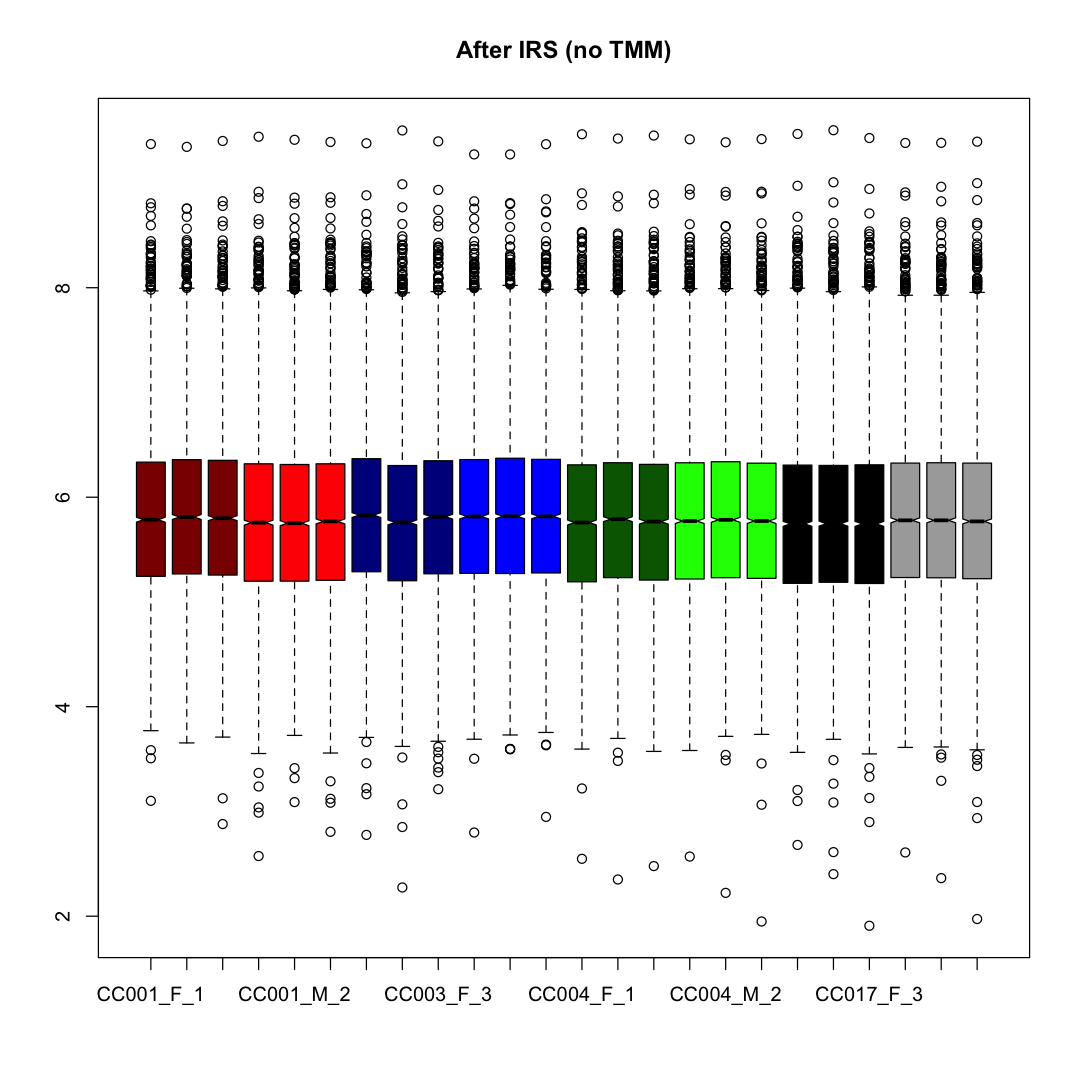

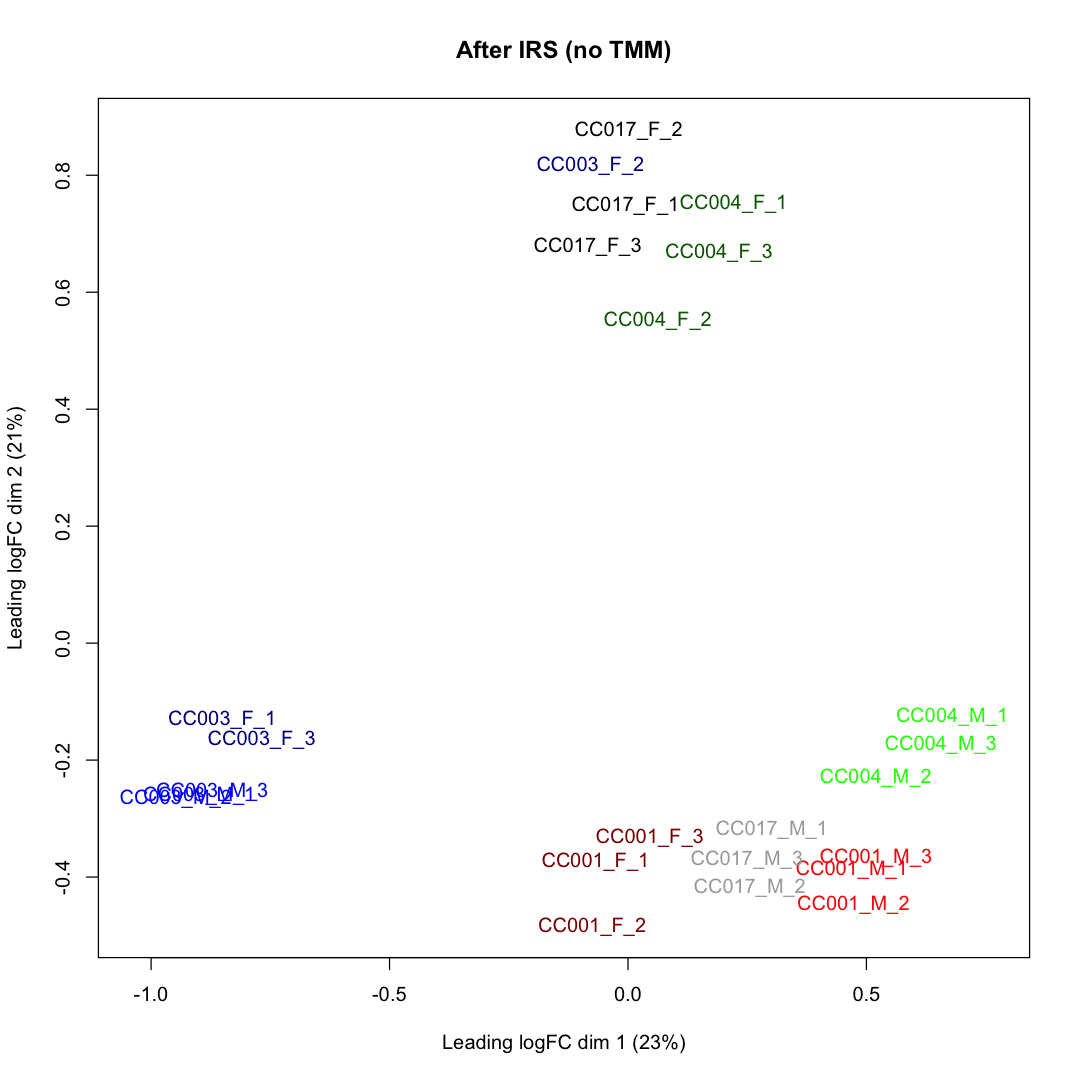

In [18]:
# make default plot sizes a little bigger
set_plot_dimensions(9, 9)

# boxplots after IRS and before TMM
boxplot(log10(tmt_irs), col = colors_group, notch = TRUE, main = "After IRS (no TMM)")

# check clustering before IRS
plotMDS(log2(tmt_irs), main = "After IRS (no TMM)", col = colors_group)

### Clustering is by strain and sex, not by plex

The last character in the sample names are the plex numbers (1, 2, or 3).

## <a name="TMM"></a>Run TMM normalization and check final clustering 

We will load the data into edgeR data structures and call the `calcNormFactors` function to perform library size and the trimmed mean of M-values (TMM) normalization to correct for any sample composition differences. We will double check if the TMM normalization changed the clustering that we had above. 

> Robinson, M.D. and Oshlack, A., 2010. A scaling normalization method for differential expression analysis of RNA-seq data. Genome biology, 11(3), p.R25.

We need to use the edgeR normalization factors to produce the TMM normalized data that the statistical testing will be working with. EdgeR uses the normalization factors in its statistical modeling but does not output the normalized intensities. We compute the normalized intensities with the `apply_tmm_factors function`.


Library size factors:
 CC001_F_1 -> 1.001466
 CC001_F_2 -> 0.994115
 CC001_F_3 -> 1.000035
 CC001_M_1 -> 0.997655
 CC001_M_2 -> 1.002345
 CC001_M_3 -> 1.000522
 CC003_F_1 -> 1.005122
 CC003_F_2 -> 1.005429
 CC003_F_3 -> 1.002714
 CC003_M_1 -> 1.004911
 CC003_M_2 -> 0.988890
 CC003_M_3 -> 1.001901
 CC004_F_1 -> 0.996335
 CC004_F_2 -> 1.008879
 CC004_F_3 -> 0.998904
 CC004_M_1 -> 0.999179
 CC004_M_2 -> 0.996309
 CC004_M_3 -> 0.997072
 CC017_F_1 -> 0.994579
 CC017_F_2 -> 1.006625
 CC017_F_3 -> 1.000246
 CC017_M_1 -> 1.001207
 CC017_M_2 -> 0.997880
 CC017_M_3 -> 0.998144

Trimmed mean of M-values (TMM) factors:
 CC001_F_1 -> 0.982489
 CC001_F_2 -> 0.939859
 CC001_F_3 -> 0.956826
 CC001_M_1 -> 1.059812
 CC001_M_2 -> 1.063876
 CC001_M_3 -> 1.044372
 CC003_F_1 -> 0.882534
 CC003_F_2 -> 1.054071
 CC003_F_3 -> 0.924657
 CC003_M_1 -> 0.926705
 CC003_M_2 -> 0.924480
 CC003_M_3 -> 0.912793
 CC004_F_1 -> 1.073482
 CC004_F_2 -> 1.007594
 CC004_F_3 -> 1.046932
 CC004_M_1 -> 1.011881
 CC004_M_2 -> 0.

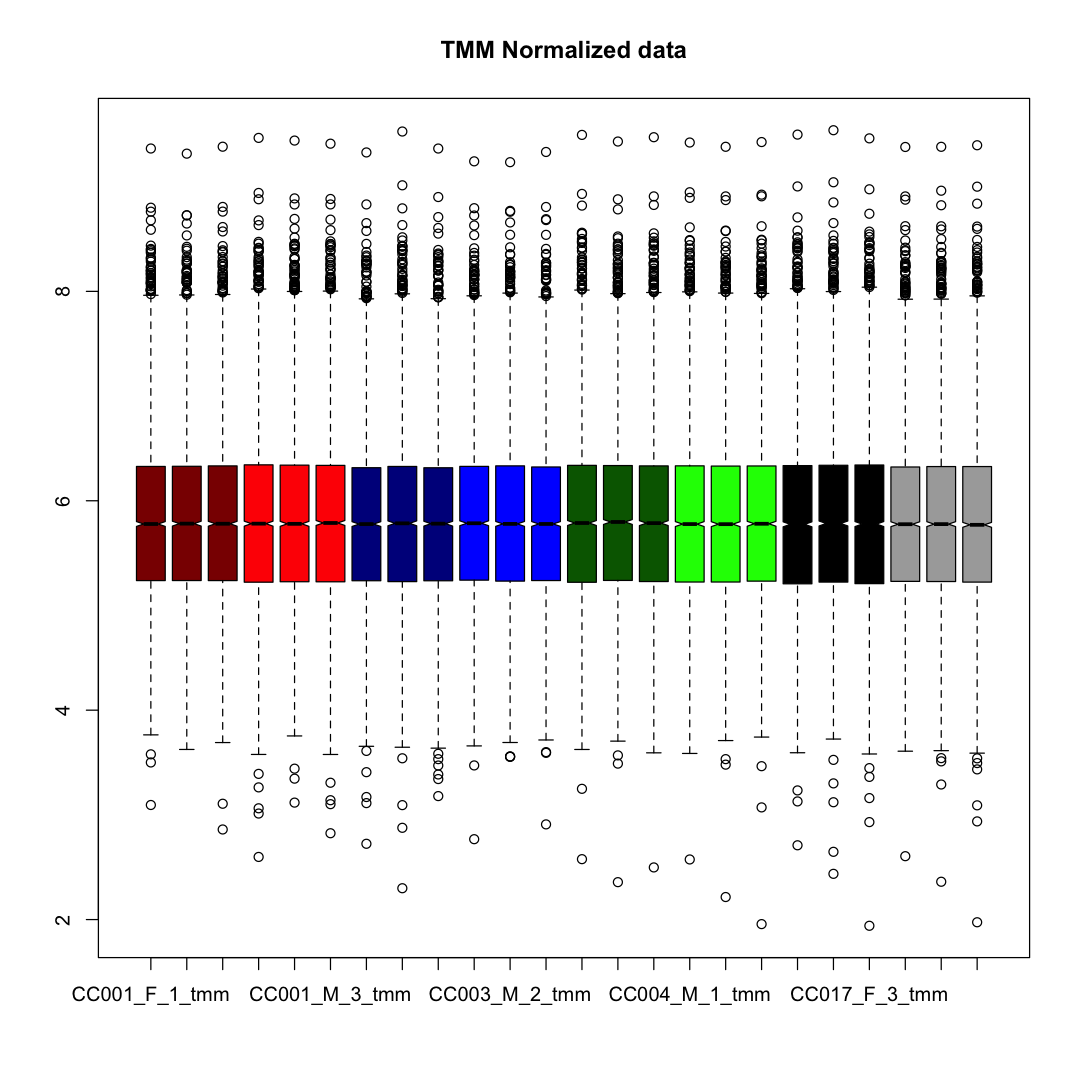

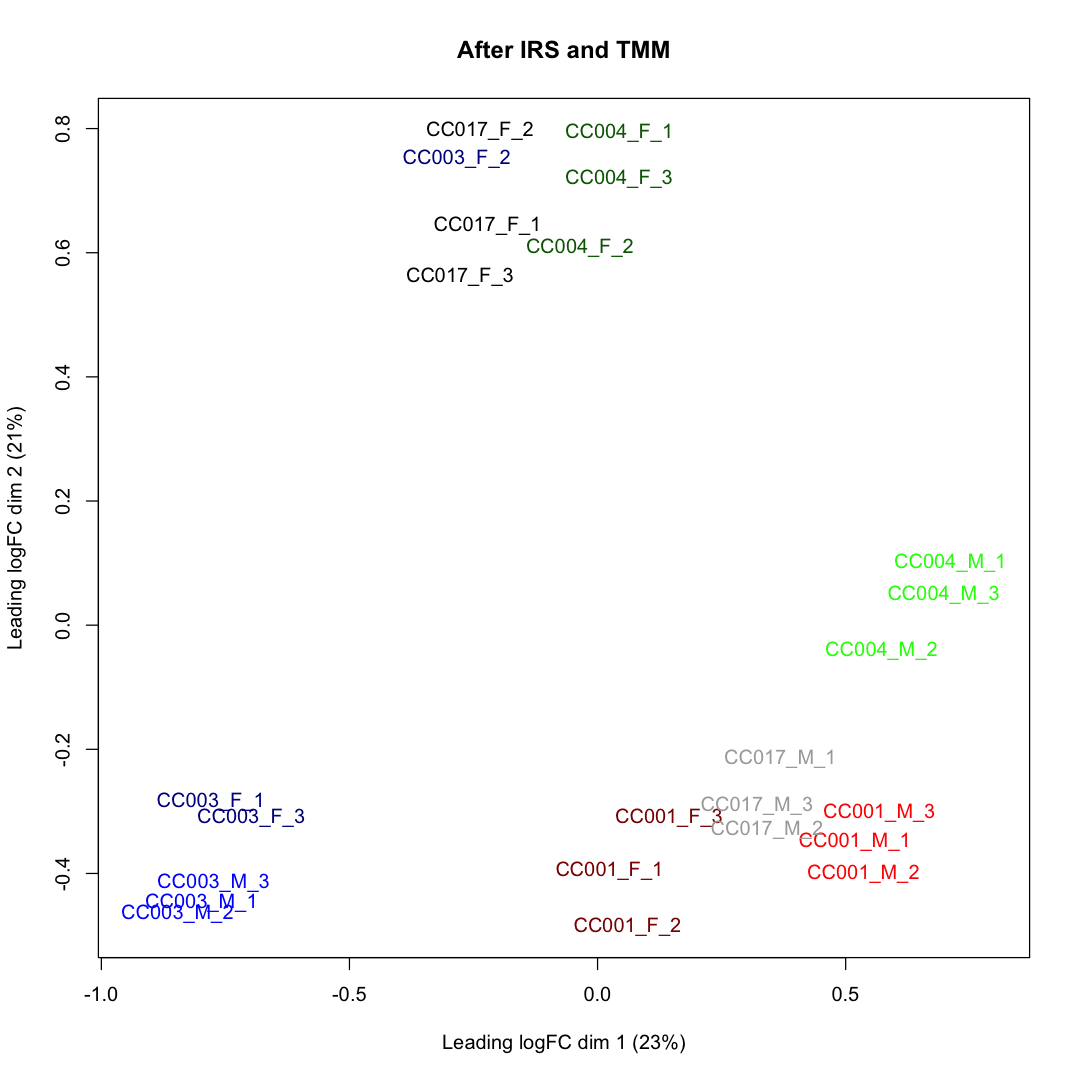

In [19]:
# get the biological sample data into a DGEList object
group = c(rep("CC001F", length(CC_001_F)), rep("CC001M", length(CC_001_M)),
          rep("CC003F", length(CC_003_F)), rep("CC003M", length(CC_003_M)),
          rep("CC004F", length(CC_004_F)), rep("CC004M", length(CC_004_M)),
          rep("CC017F", length(CC_017_F)), rep("CC017M", length(CC_017_M)))

y <- DGEList(counts = tmt_irs, group = group, genes = accessions)

# run TMM normalization (also includes a library size factor)
y <- calcNormFactors(y)

# compute the TMM-normalized intensities
tmt_tmm <- apply_tmm_factors(y, color = colors_group)

# write the TMM-normalized intensities to file
write.table(cbind(accessions,tmt_tmm), "CC_IRS-plus-TMM.txt", sep = "\t", 
            row.names = FALSE, na =  " ")

# check the clustering
plotMDS(y, col = colors_group, main = "After IRS and TMM")

### TMM factors are close to 1.0

Mouse liver samples look like a good tissue to process. Boxplots and normalization factors all suggest good sample-to-sample similarity. The TMM-normalization improved the boxplot alignment and tightened up the clustering a little bit. Interestingly, the `CC003_F_2` sample clusters with the `CC017_F` samples (upper center) rather than with the rest of its group (lower left corner).

## <a name="CVs"></a>Check CV distributions

The distributions of Coefficients of Variation (CVs) are another way to get an idea of how individual proteins are behaving. This is an effective way to assess proper normalization in these experiments. We will compute CV distributions for each of the biological conditions.

In [20]:
# put CVs in data frames to simplify plots and summaries
# we will skip the n=1 group (TOFPS)
cv_tmm <- data.frame(CC001F = CV(tmt_tmm[CC001F]), CC001M = CV(tmt_tmm[CC001M]),
                     CC003F = CV(tmt_tmm[CC003F]), CC003M = CV(tmt_tmm[CC003M]),
                     CC004F = CV(tmt_tmm[CC004F]), CC004M = CV(tmt_tmm[CC004M]),
                     CC017F = CV(tmt_tmm[CC017F]), CC017M = CV(tmt_tmm[CC017M]))

medians <- apply(cv_tmm, 2, FUN = median)
print("Final median CVs by condition (%)")
round(medians, 2)

[1] "Final median CVs by condition (%)"


CC001F CC001M CC003F CC003M CC004F CC004M CC017F CC017M 
  6.41   6.44  10.21   7.67   5.40   5.13   8.31   5.69

### Average median CV is 6.9%

Laboratory animals can have quite small median CVs provided the tissue is not especially challenging to process. Good technical replicates can have median CVs in the 3% range. Animal model can be in the 5-7% range for good sample preps up to maybe low teens for harder samples of less reproducible sample processing.

### Use ggplot to visualize the CV distributions

We will look at the final TMM normalized data only.

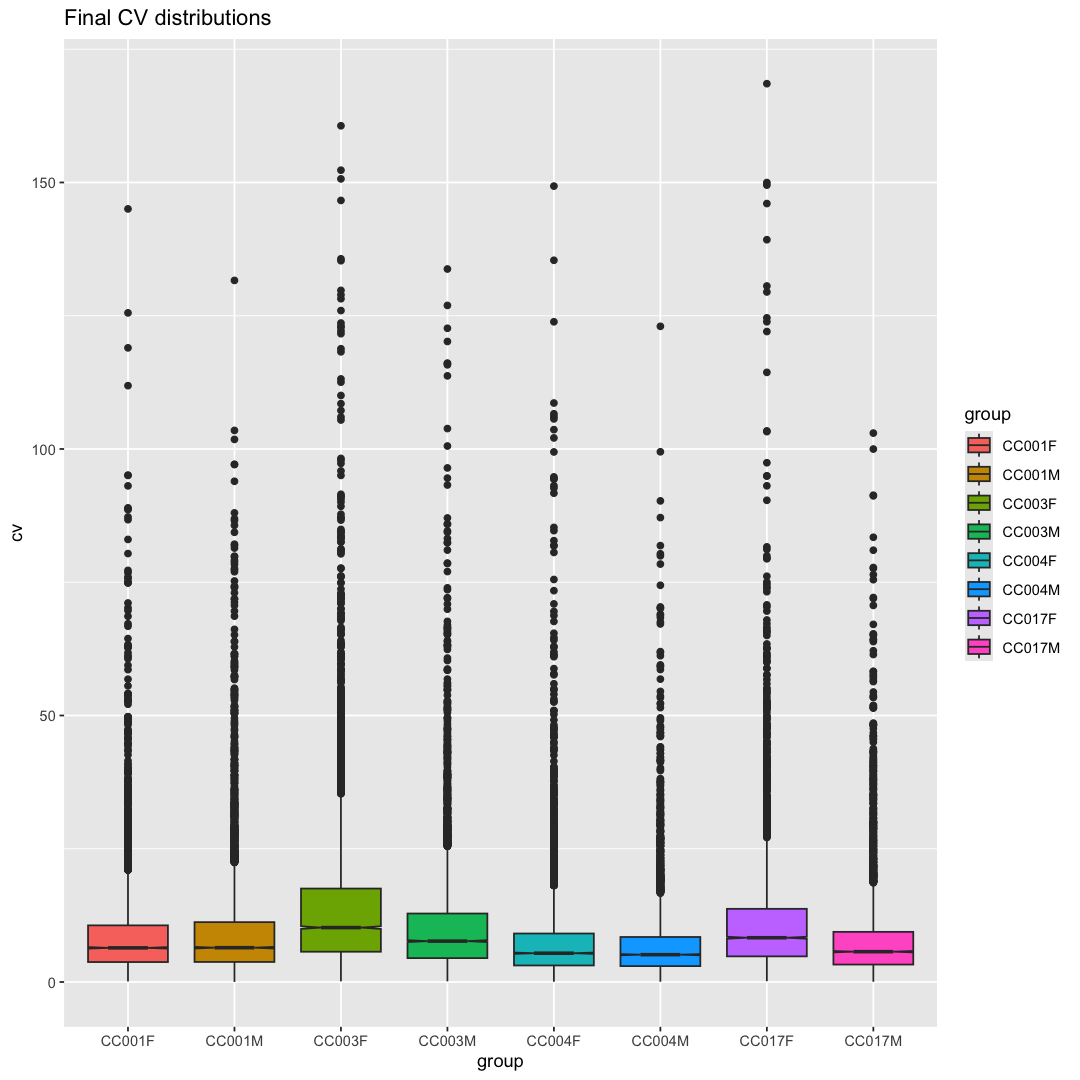

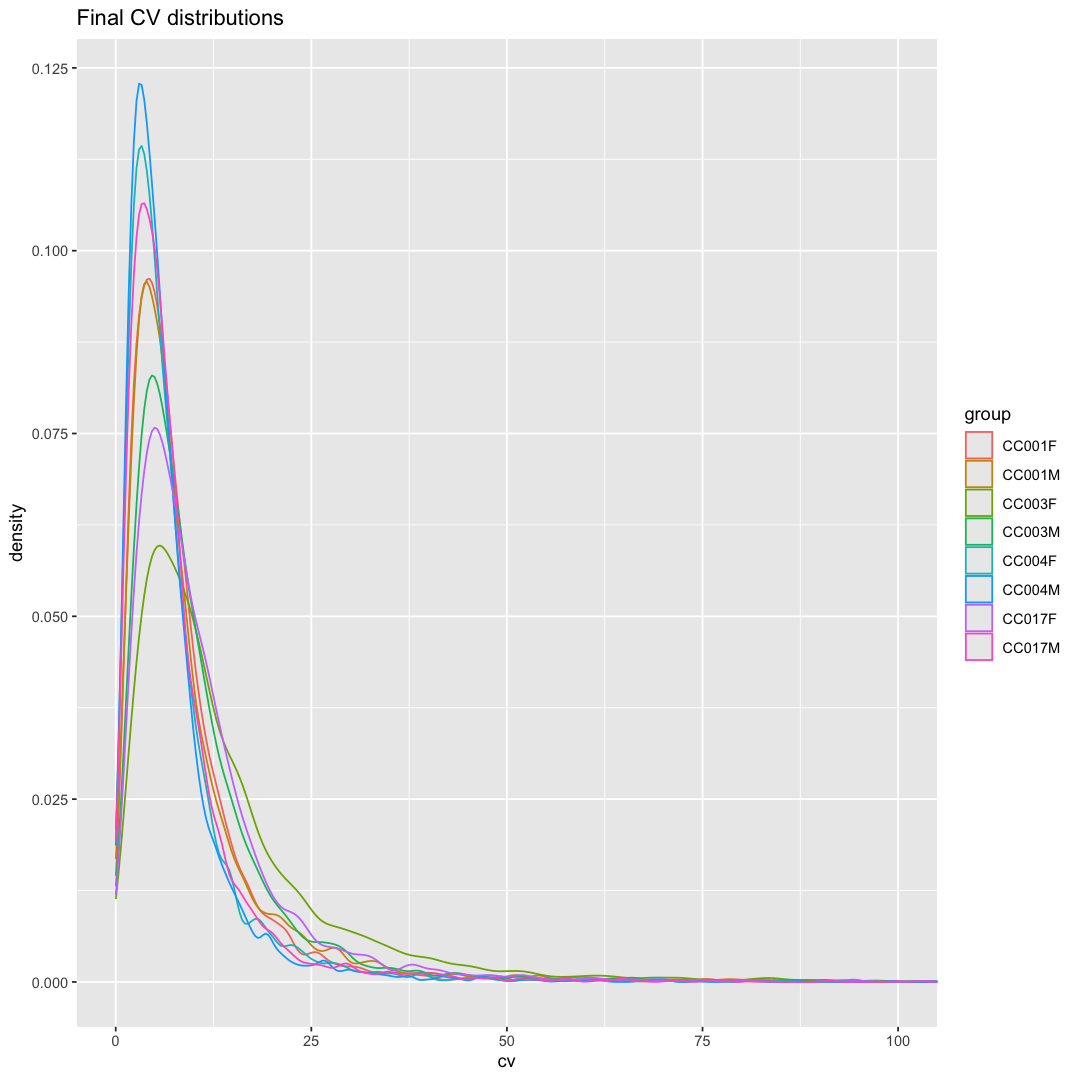

In [21]:
# see what the CV distibutions look like
# need long form for ggplot
long_cv_tmm <- gather(cv_tmm, key = "group", value = "cv") 

# traditional boxplots
ggplot(long_cv_tmm, aes(x = group, y = cv, fill = group)) +
  geom_boxplot(notch = TRUE) +
  ggtitle("Final CV distributions")

# density plots
ggplot(long_cv_tmm, aes(x = cv, color = group)) +
  geom_density() +
  coord_cartesian(xlim = c(0, 100)) +
  ggtitle("Final CV distributions")

### `CC003_F` and `CC017_F` groups have broader CV distributions

The boxplots for these two groups have higher median CVs and a larger interquartile range. The CV density plots show a little more right-side tailing and broader distributions for the two groups, too.

## <a name="scatter_plots"></a>Compare sample scatter plots for each biological condition

We can also look at each biological condition with a multi-panel scatter plot grid and see how similar the replicates are to each other. We can look at the intensities after IRS with TMM (final data).

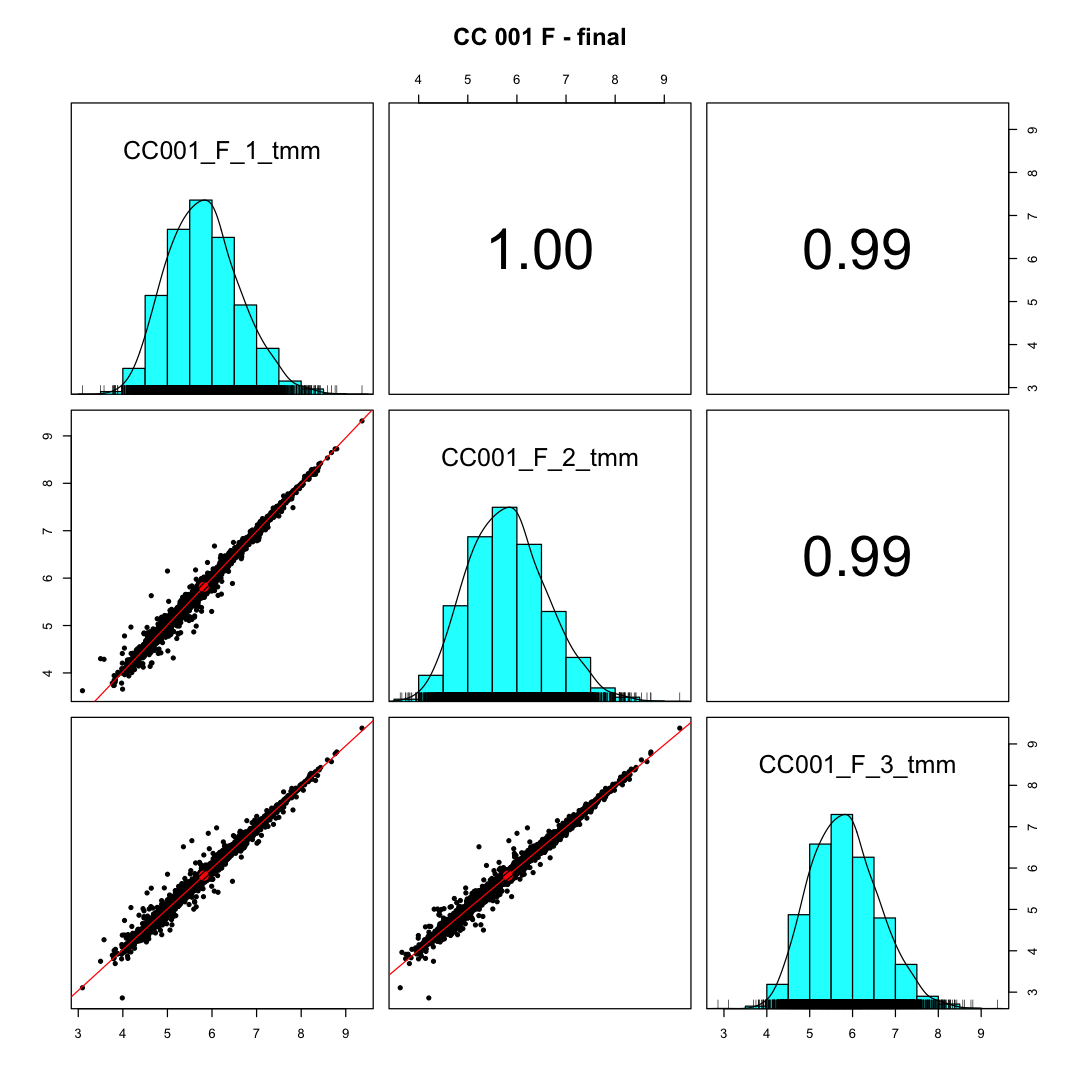

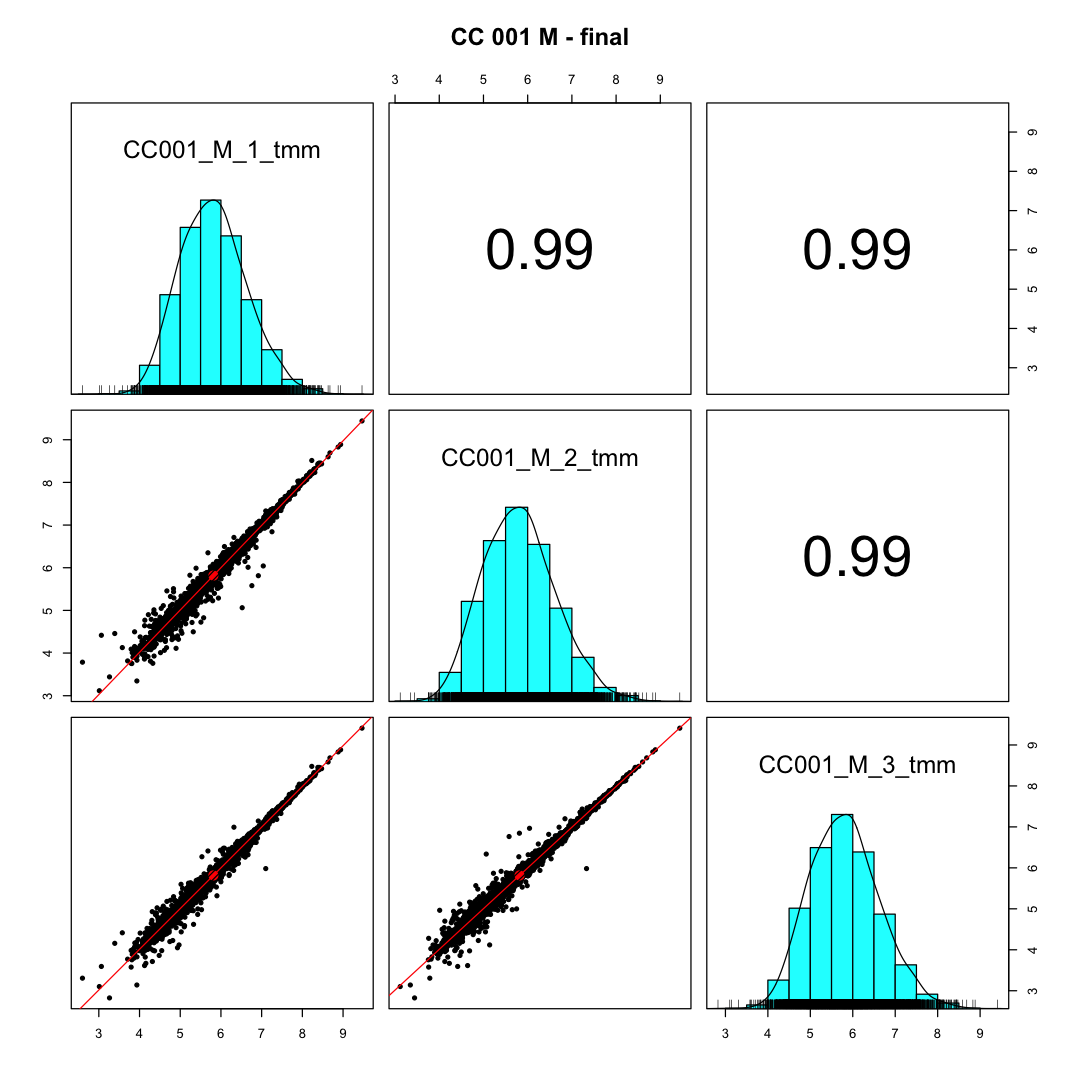

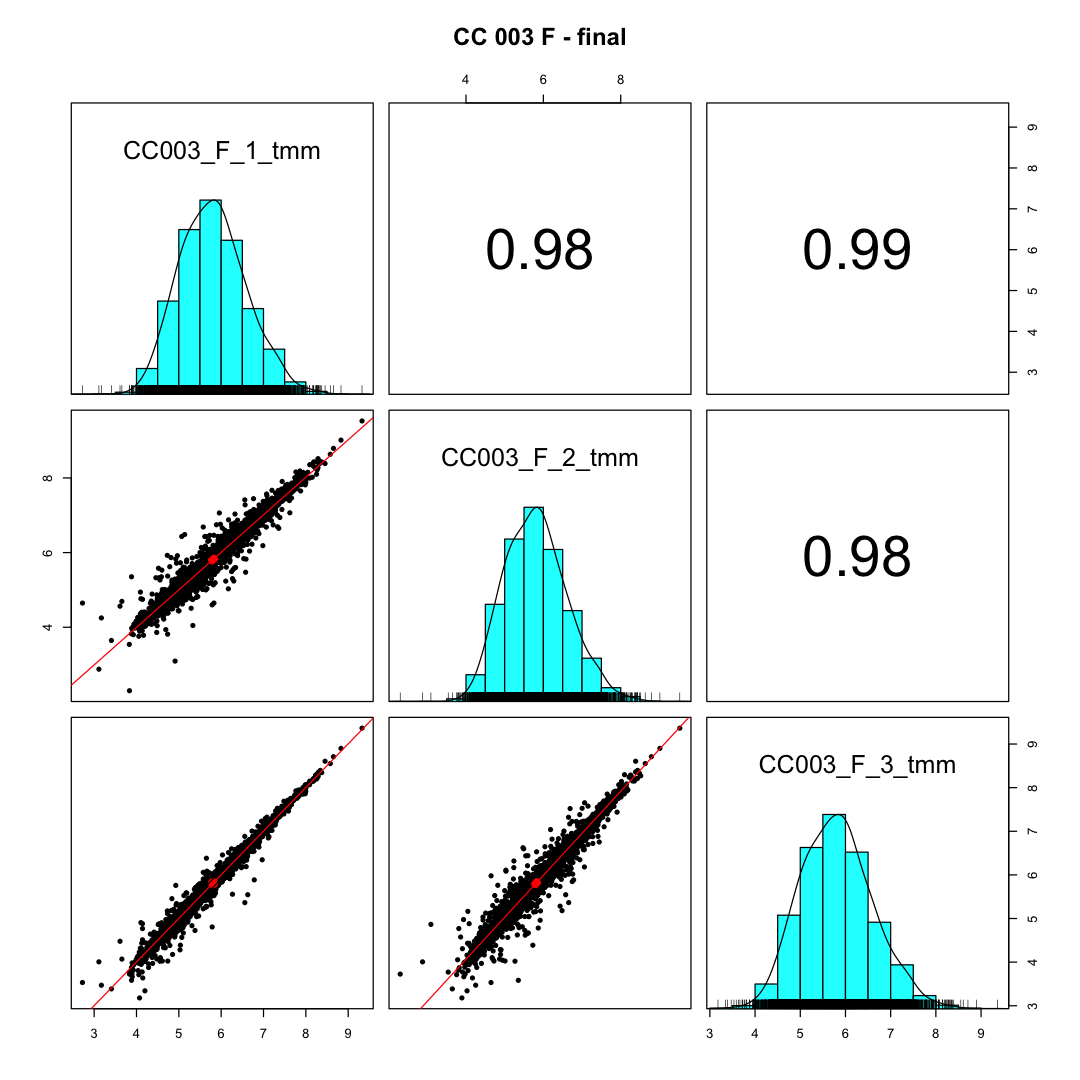

In [22]:
# multi-panel scatter plot grids, final data
pairs.panels(log10(tmt_tmm[CC001F]), lm = TRUE, main = "CC 001 F - final")

pairs.panels(log10(tmt_tmm[CC001M]), lm = TRUE, main = "CC 001 M - final")

pairs.panels(log10(tmt_tmm[CC003F]), lm = TRUE, main = "CC 003 F - final")

#### `CC003_F_2` is not so similar to the other two `CC003_F` samples

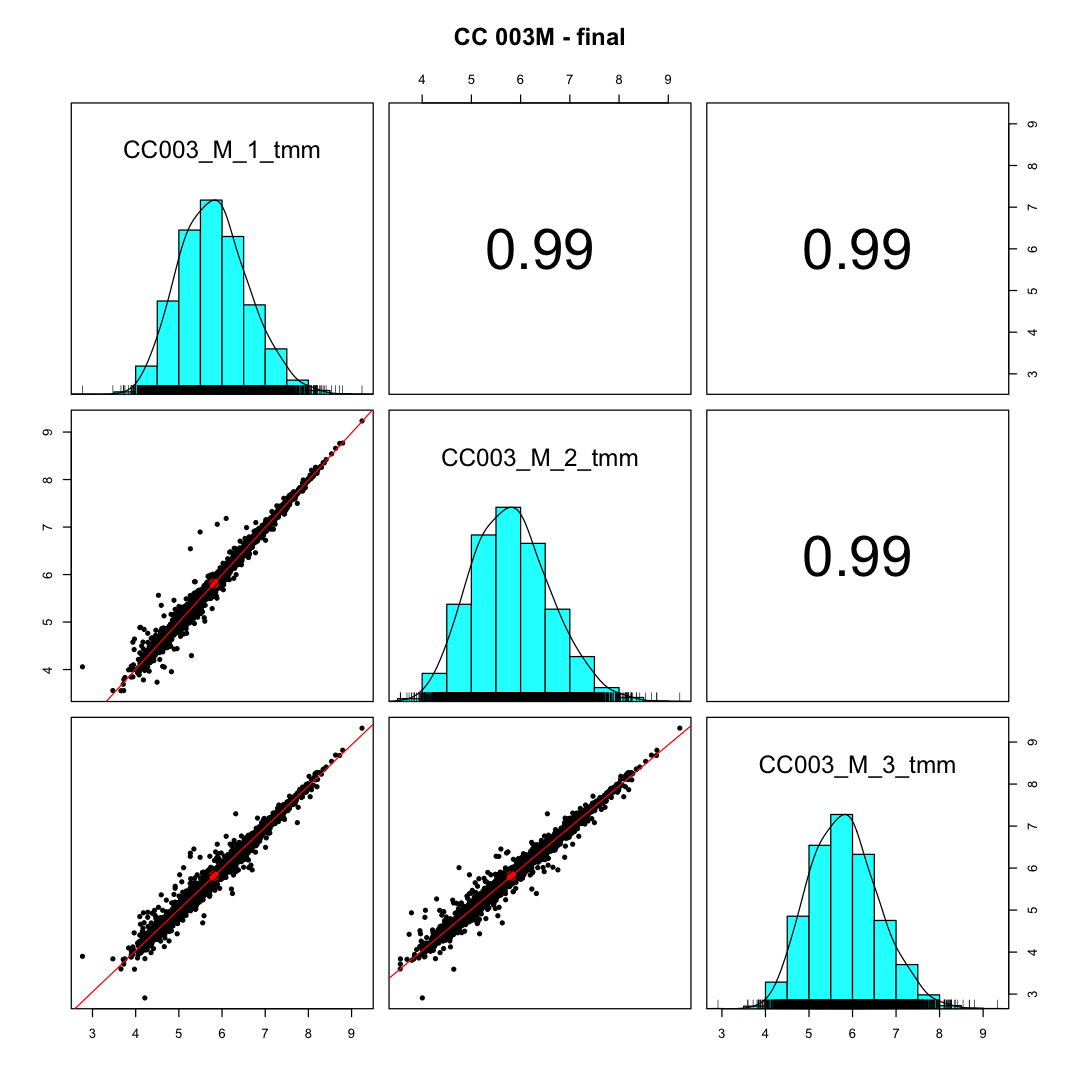

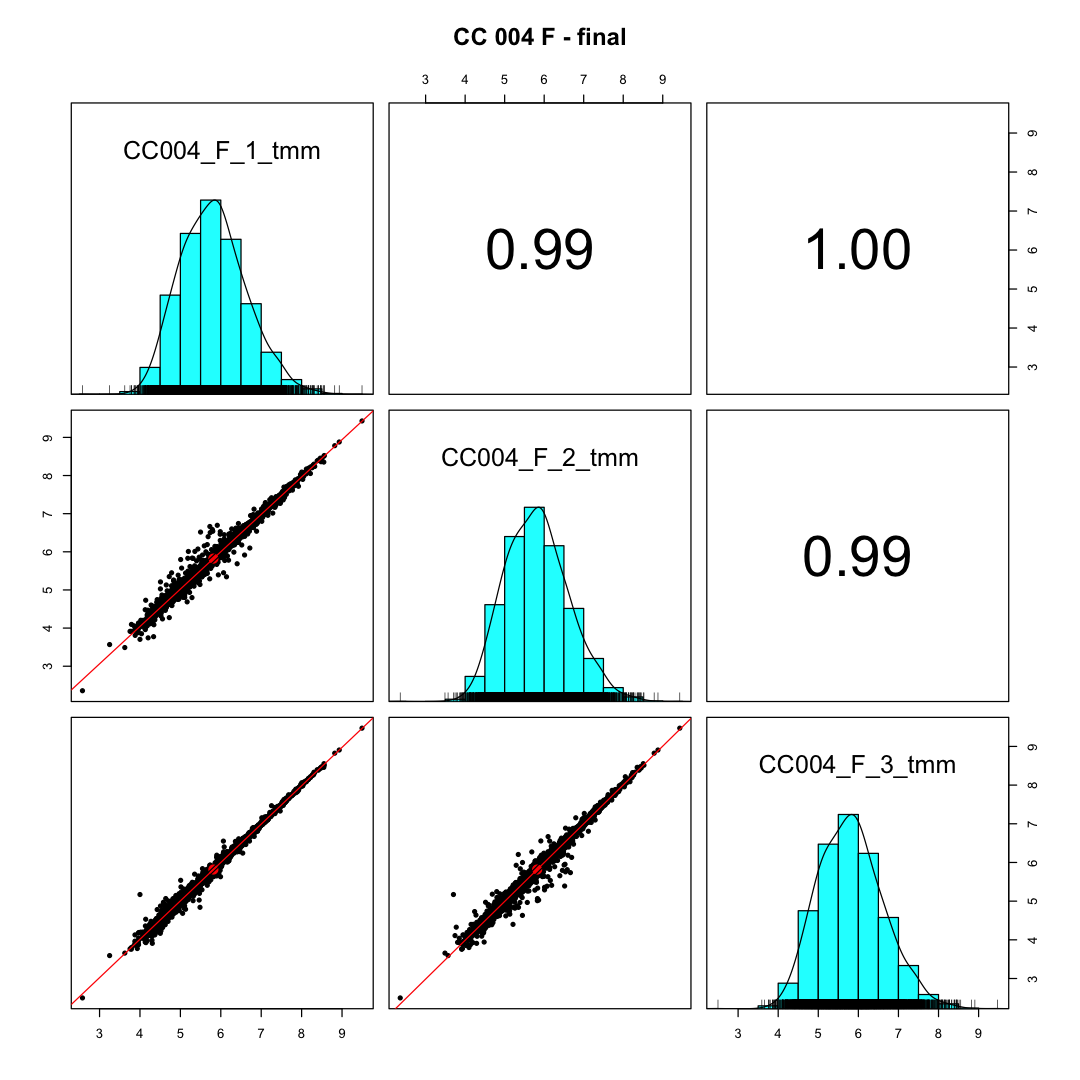

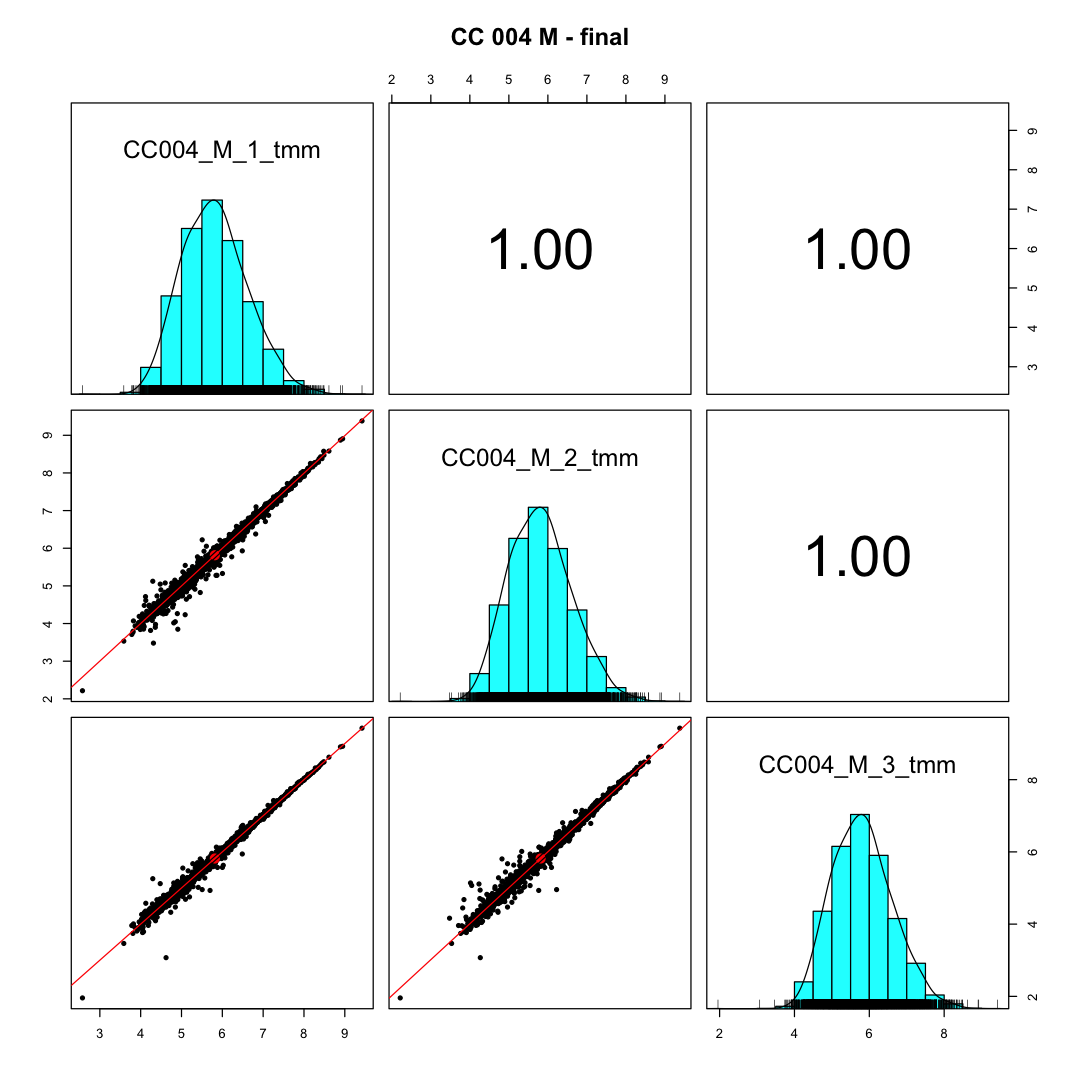

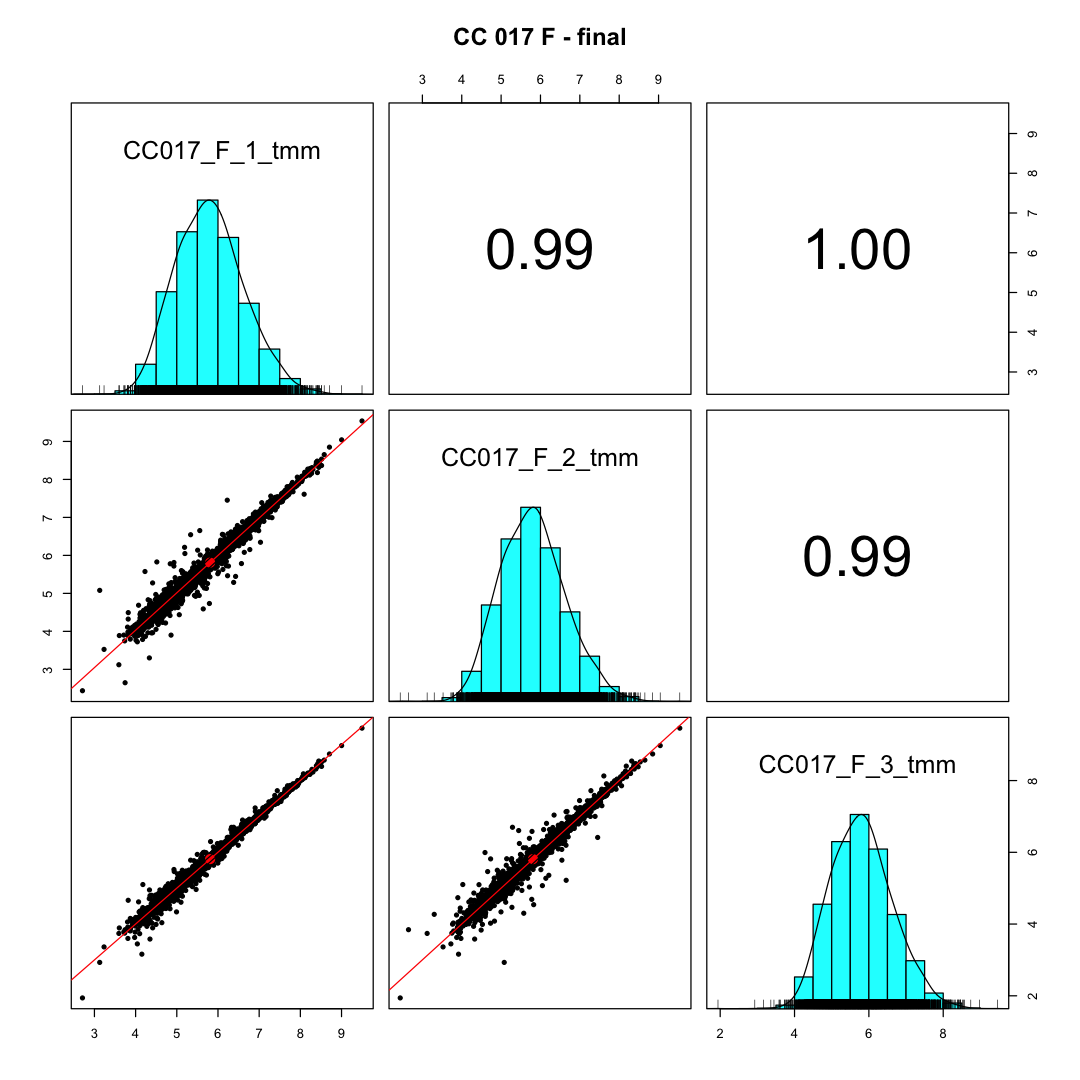

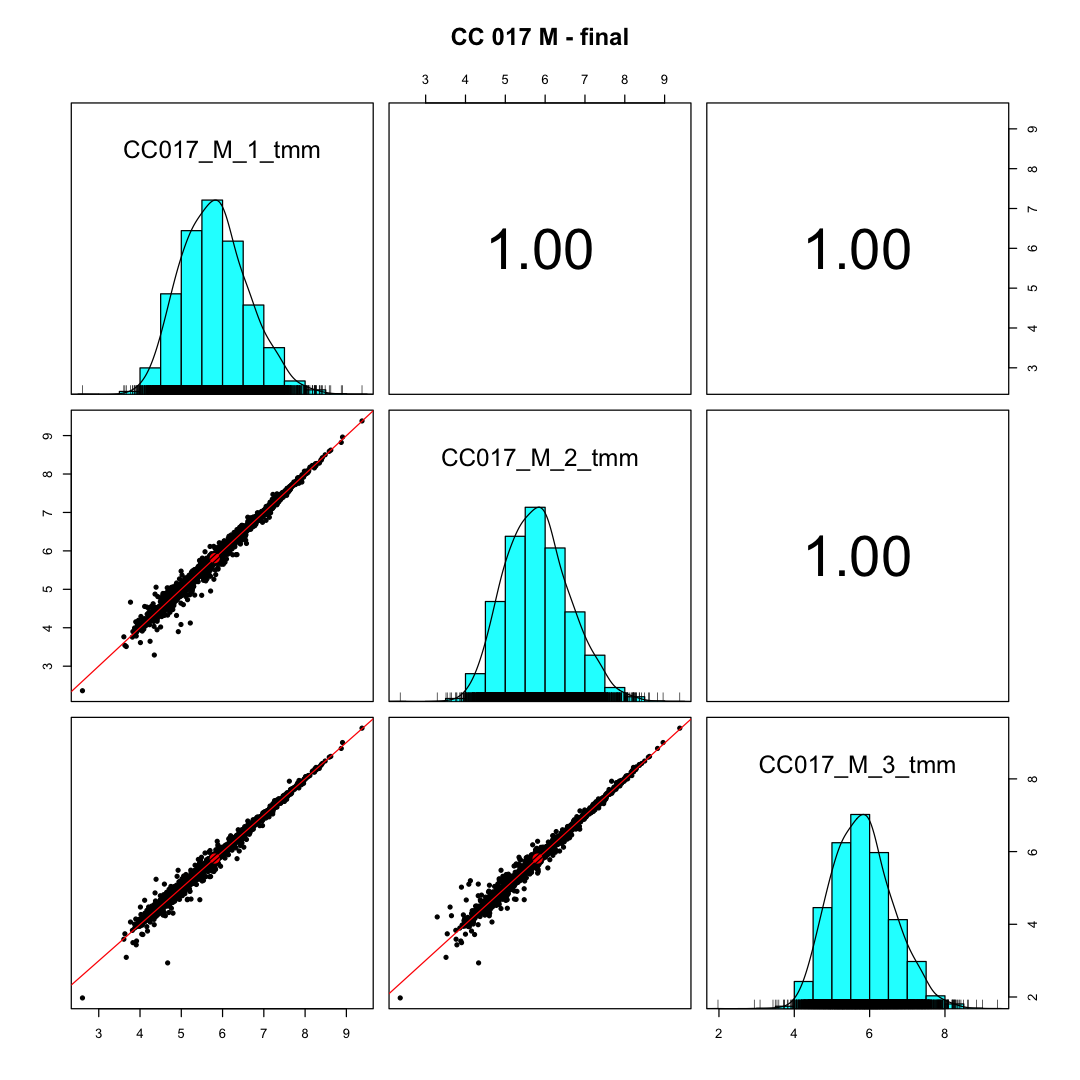

In [23]:
pairs.panels(log10(tmt_tmm[CC003M]), lm = TRUE, main = "CC 003M - final")

pairs.panels(log10(tmt_tmm[CC004F]), lm = TRUE, main = "CC 004 F - final")

pairs.panels(log10(tmt_tmm[CC004M]), lm = TRUE, main = "CC 004 M - final")

pairs.panels(log10(tmt_tmm[CC017F]), lm = TRUE, main = "CC 017 F - final")

pairs.panels(log10(tmt_tmm[CC017M]), lm = TRUE, main = "CC 017 M - final")

### Sample-to-sample correlations are good

Sample-to-sample scatter within groups is small for the 24-sample dataset. This was a balanced study design, and the mock reference channel approach should work well.

### Compare averages of each group to each other

We can get a little heads up on the statistical testing by comparing group averages to each other. 

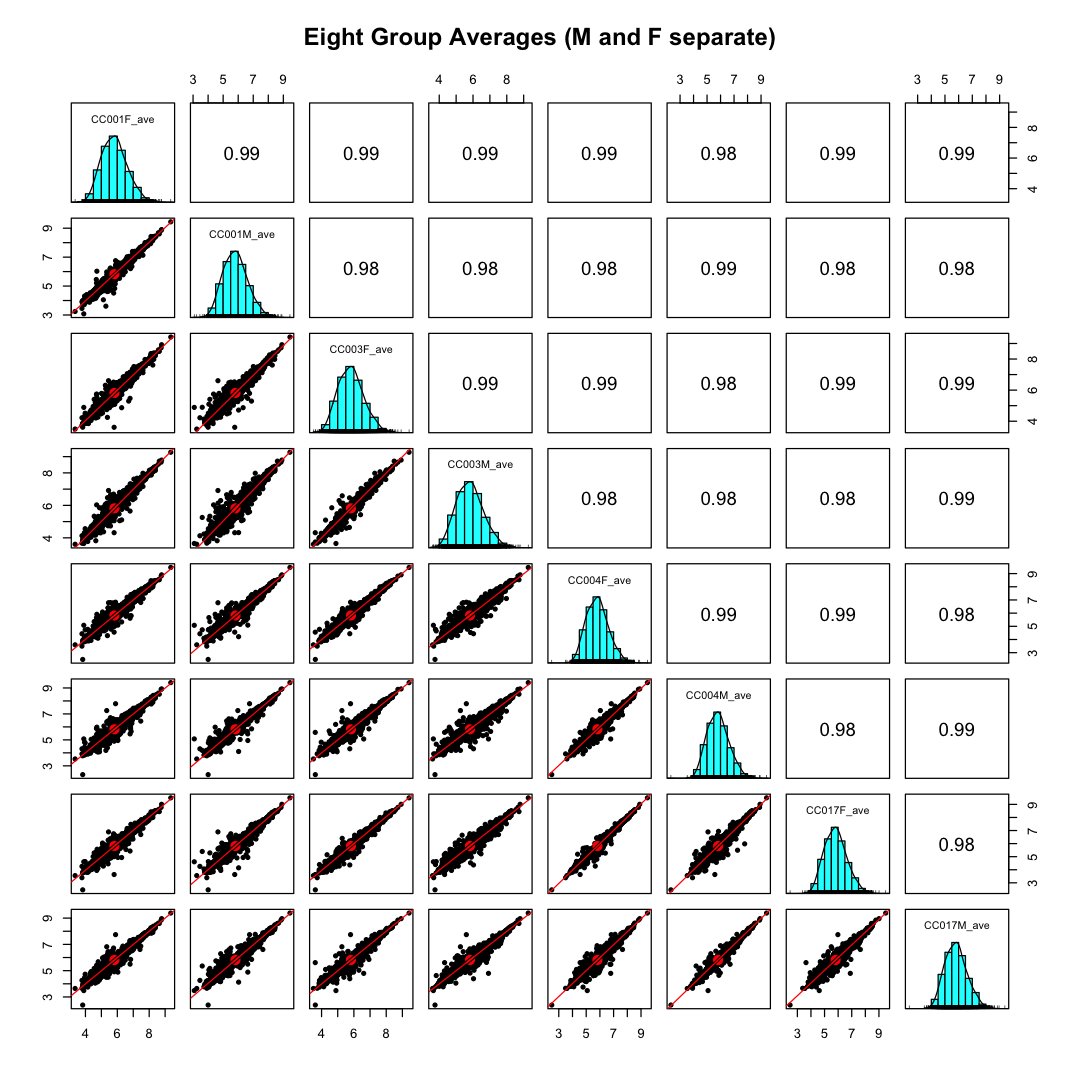

In [24]:
# save the dataframe with the averages by strain and sex
ave_tmm <- cbind(CC001F_ave = rowMeans(tmt_tmm[CC001F]),
                 CC001M_ave = rowMeans(tmt_tmm[CC001M]),
                 CC003F_ave = rowMeans(tmt_tmm[CC003F]),
                 CC003M_ave = rowMeans(tmt_tmm[CC003M]),
                 CC004F_ave = rowMeans(tmt_tmm[CC004F]),
                 CC004M_ave = rowMeans(tmt_tmm[CC004M]),
                 CC017F_ave = rowMeans(tmt_tmm[CC017F]),
                 CC017M_ave = rowMeans(tmt_tmm[CC017M]))

# make a scatter plot grid for the group averages
pairs.panels(log10(ave_tmm), lm = TRUE, main = "Eight Group Averages (M and F separate)")

#### Scatter plot grid is hard to interpret with 8 groups

Separation by sex in addition to the 4 strains creates 8 groups and makes the scatter plot grid hard to process. We can combine sexes and just look at the 4 strain averages.

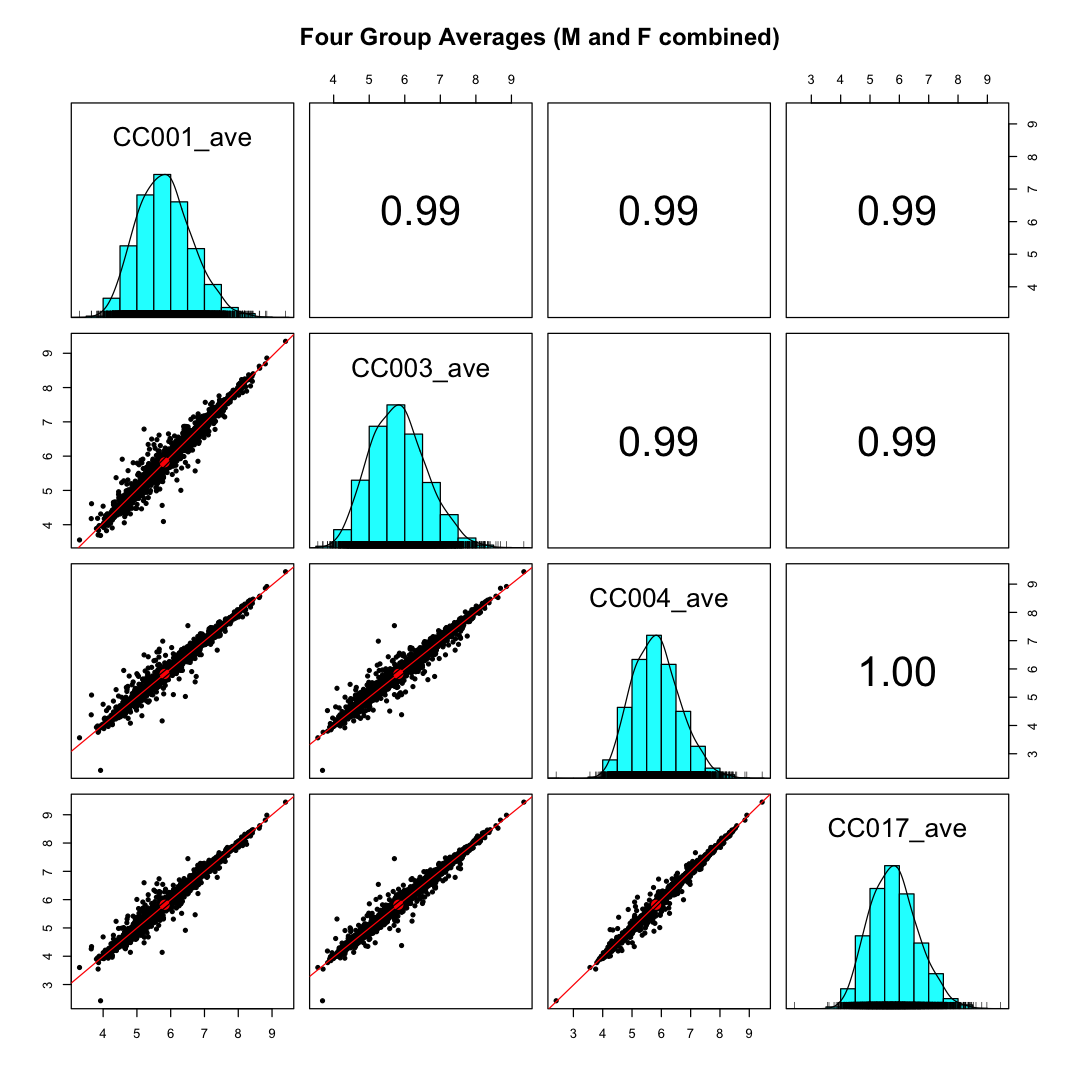

In [25]:
# save the dataframe with the averages by developmental age
ave_tmm <- cbind(CC001_ave = rowMeans(tmt_tmm[c(CC001F, CC001M)]),
                 CC003_ave = rowMeans(tmt_tmm[c(CC003F, CC003M)]),
                 CC004_ave = rowMeans(tmt_tmm[c(CC004F, CC004M)]),
                 CC017_ave = rowMeans(tmt_tmm[c(CC017F, CC017M)]))

# make a scatter plot grid for the group averages
pairs.panels(log10(ave_tmm), lm = TRUE, main = "Four Group Averages (M and F combined)")

#### Some strains are more similar, and some are more different

Strain number 3 seems to differ from strains 1 and 4.

## <a name="summary"></a> Summary

Quality control checks seem okay. The balanced study design lends itself to IRS using plex averages as a mock reference channel. We can move on to statistical testing.

## Log the session information

In [26]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-apple-darwin20
Running under: macOS 15.7.2

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] psych_2.4.3     edgeR_4.2.0     limma_3.60.2    scales_1.3.0   
 [5] lubridate_1.9.3 forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4    
 [9] purrr_1.0.2     readr_2.1.5     tidyr_1.3.1     tibble_3.2.1   
[13] ggplot2_3.5.1   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] utf8_1.2.4        generics_0.1.3    stringi_1.8.4     lattice_0.22-6   
 [5] hms_1.1.3         digest_0.6.35     magrittr_2.0.3  